In [391]:
#Libraries
import numpy as np 
import pandas as pd 
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import date
import pandas_datareader as data
from pandas_datareader import *
import math
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Model
#Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

In [392]:
#Scraping Dataset from Yahoo Finance using yfinance
#Getting data for the Apple Stock
aapl = yf.Ticker("AAPL")

# Apple Company Information
# aapl.info

# Apple's Historical Stock Prices (10 Year Period)
aapl.dataset = aapl.history(period="10y")

aapl.dataset.tail(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-04-18,163.919998,166.600006,163.570007,165.070007,69023900,0.0,0.0
2022-04-19,165.020004,167.820007,163.910004,167.399994,67723800,0.0,0.0
2022-04-20,168.759995,168.880005,166.100006,167.229996,67929800,0.0,0.0
2022-04-21,168.910004,171.529999,165.910004,166.419998,87227800,0.0,0.0
2022-04-22,166.460007,167.869995,161.500000,161.789993,84775200,0.0,0.0
2022-04-25,161.119995,163.169998,158.460007,162.880005,96046400,0.0,0.0
2022-04-26,162.250000,162.339996,156.720001,156.800003,95623200,0.0,0.0
2022-04-27,155.910004,159.789993,155.380005,156.570007,88063200,0.0,0.0
2022-04-28,159.250000,164.520004,158.929993,163.639999,115586400,0.0,0.0


In [393]:
#Dataframe basic information on rows and columns
aapl.dataset.shape

(2518, 7)

In [394]:
#Dropped Columns 'Dividends' and 'Stock Splits'
aapl.dataset.drop(['Dividends', 'Stock Splits'], axis=1)

,Open,High,Low,Close,Volume
Date,,,,,
2012-04-30,18.281457,18.299806,17.828854,17.858824,506144800
2012-05-01,17.886958,18.249651,17.774725,17.802248,610999200
2012-05-02,17.744443,17.963405,17.702241,17.919979,427389200
2012-05-03,18.058217,18.085740,17.746287,17.792770,390549600
2012-05-04,17.647810,17.686953,17.283587,17.286034,529992400
...,...,...,...,...,...
2022-04-25,161.119995,163.169998,158.460007,162.880005,96046400
2022-04-26,162.250000,162.339996,156.720001,156.800003,95623200
2022-04-27,155.910004,159.789993,155.380005,156.570007,88063200


In [395]:
#YFinance Bug- Dropped columns appears after being dropped so copying into new dataset
dataset = aapl.dataset [['Open', 'Close', 'High', 'Low','Volume']].copy()
dataset.tail()

,Open,Close,High,Low,Volume
Date,,,,,
2022-04-25,161.119995,162.880005,163.169998,158.460007,96046400
2022-04-26,162.250000,156.800003,162.339996,156.720001,95623200
2022-04-27,155.910004,156.570007,159.789993,155.380005,88063200
2022-04-28,159.250000,163.639999,164.520004,158.929993,115586400
2022-04-29,161.839996,159.750000,166.199997,159.589996,79660339


ADDING TECHNICAL INDICATORS TO DATASET

Stochastic Oscillator Indicator

In [396]:
# Calculating %K and %D
dataset['14-high'] = dataset['High'].rolling(14).max()
dataset['14-low'] = dataset['Low'].rolling(14).min()
dataset['%K'] = (dataset['Close'] - dataset['14-low'])*100/(dataset['14-high'] - dataset['14-low'])
dataset['%D'] = dataset['%K'].rolling(3).mean()


In [397]:
#Dropping 14-HIGH AND 14-LOW COLUMNS
dataset.drop(['14-high', '14-low'], axis = 1, inplace=True)

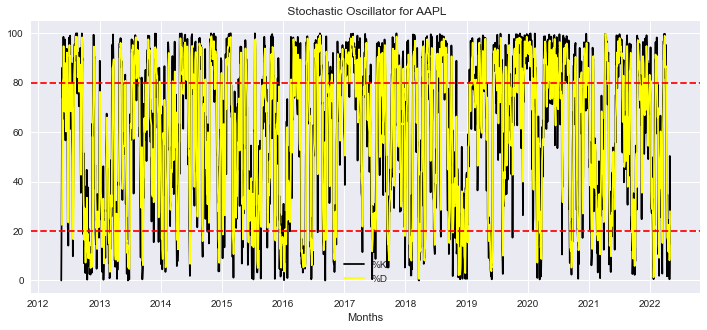

In [398]:
#Plotting SO Graph
plt.figure(figsize=(12, 5))
plt.title(' Stochastic Oscillator for AAPL')
plt.xlabel('Months')
plt.plot(dataset['%K'], label='%K', c='black')
plt.plot(dataset['%D'], label='%D',  c='yellow')
plt.axhline(20, linestyle='--', color="r")
plt.axhline(80, linestyle="--", color="r")
plt.legend()
plt.show()


In [399]:
# Adding Buy/Sell Signals from Sotchastic Oscillator Indicator
def categorise_so(row):  
    if row['%K'] <= 20 and row['%D'] <= 20:
        return 'Buy'
    elif row['%K'] >= 80 and  row['%D']>= 80:
        return 'Sell'
    else:
        return 'Hold'

    
   
dataset['SO Indicator'] = dataset.apply(lambda row: categorise_so(row), axis=1)


In [400]:
# Distrubition of the Indicator
print(dataset['SO Indicator'].value_counts())

Hold    1553
Sell     725
Buy      240
Name: SO Indicator, dtype: int64


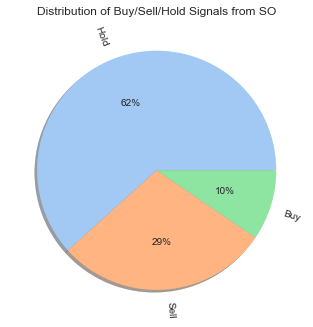

In [401]:
#Distrubition of the SO Indicator
labels = ["Hold", "Sell", "Buy"]
values = dataset['SO Indicator'].value_counts().tolist()
colours = sns.color_palette("pastel")
plt.pie(x=values, labels=labels, autopct='%.0f%%', colors= colours, shadow=True, rotatelabels='true')
plt.title("Distribution of Buy/Sell/Hold Signals from SO")
plt.show()

Relative Strength Index

In [402]:
delta = dataset['Close'].diff()
up = delta.clip(lower=0)
down = -1*delta.clip(upper=0)
ema_up = up.ewm(com=13, adjust=False).mean()
ema_down = down.ewm(com=13, adjust=False).mean()
rs = ema_up/ema_down
dataset['RSI'] = 100 - (100/(1 + rs))

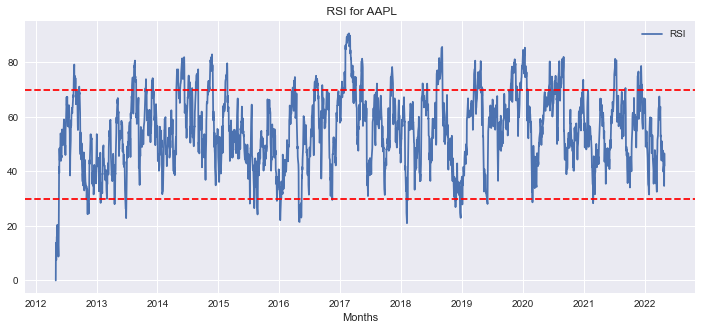

In [403]:
#Plotting RSI Graph
plt.figure(figsize=(12, 5))
plt.title(' RSI for AAPL')
plt.xlabel('Months')
plt.plot(dataset['RSI'], label='RSI')
plt.axhline(30, linestyle='--', color="r")
plt.axhline(70, linestyle="--", color="r")
plt.legend()
plt.show()



In [404]:
# Adding Buy/Sell Signals from RSI Indicator
def categorise_rsi(row):  
    if row['RSI'] <= 30:
        return 'Buy'
    elif row['RSI'] >= 70:
        return 'Sell'
    else:
        return 'Hold'
  
dataset['RSI Indicator'] = dataset.apply(lambda row: categorise_rsi(row), axis=1)

In [405]:
# Distrubition of the Indicator
print(dataset['RSI Indicator'].value_counts())

Hold    2080
Sell     362
Buy       76
Name: RSI Indicator, dtype: int64


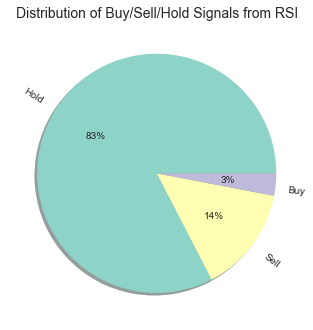

In [406]:
#Distrubition of the Indicator
labels = ["Hold", "Sell", "Buy"]
values = dataset['RSI Indicator'].value_counts().tolist()
plt.style.use("seaborn")
colours = sns.color_palette("Set3")
plt.pie(x=values, labels=labels, autopct='%.0f%%', colors= colours, shadow=True, rotatelabels='true')
plt.title("Distribution of Buy/Sell/Hold Signals from RSI", fontdict={'fontsize': 14})
plt.show()

Bollinger Bands

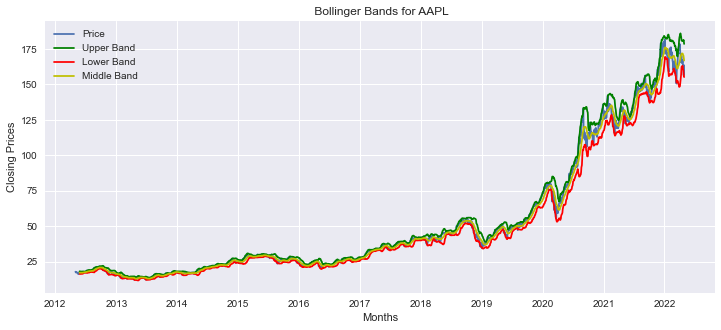

In [407]:
def get_sma(prices, rate):
    return prices.rolling(rate).mean()

def get_bollinger_bands(prices, rate=20):
    # SMA for 20 Days (Middle Band)
    sma = get_sma(prices, rate)
    std = prices.rolling(rate).std()

    # Calculating Upper Band
    bollinger_upper = sma + (std * 2 )

    # Calculate Lower Band
    bollinger_lower = sma - (std * 2 )

    #Middle Band
    bollinger_middle = sma
    return bollinger_upper, bollinger_lower, bollinger_middle


closing_prices = dataset['Close']
bollinger_upper, bollinger_lower, bollinger_middle = get_bollinger_bands(closing_prices)

#Plotting the  Bollinger Bands
plt.figure(figsize=(12, 5))
plt.title(' Bollinger Bands for AAPL')
plt.xlabel('Months')
plt.ylabel('Closing Prices')
plt.plot(closing_prices, label='Price')
plt.plot(bollinger_upper, label='Upper Band', c='g')
plt.plot(bollinger_lower, label='Lower Band', c='r')
plt.plot(bollinger_middle, label='Middle Band', c='y')

plt.legend()
plt.show()

In [408]:
#Adding Bollinger Bands to the Dataset
dataset['Bollinger_Upper'] = bollinger_upper
dataset['Bollinger_Lower'] = bollinger_lower


In [409]:
# Adding Buy/Sell Signals from Bollinger Bands Indicator
def categorise_bollinger(row):  
    if row['Close'] < row['Bollinger_Lower']:
        return 'Buy'
    elif row['Close'] > row['Bollinger_Upper']:
        return 'Sell'
    else:
        return 'Hold'
    
   
dataset['Bollinger Indicator'] = dataset.apply(lambda row: categorise_bollinger(row), axis=1)


In [410]:
# Distrubition of the Indicator
print(dataset['Bollinger Indicator'].value_counts())

Hold    2220
Sell     188
Buy      110
Name: Bollinger Indicator, dtype: int64


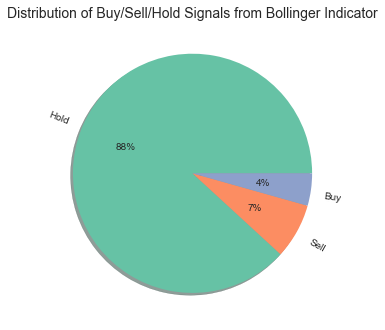

In [411]:
#Distrubition of the Indicator
labels = ["Hold", "Sell", "Buy"]
values = dataset['Bollinger Indicator'].value_counts().tolist()
plt.style.use("seaborn")
colours = sns.color_palette("Set2")
plt.pie(x=values, labels=labels, autopct='%.0f%%', colors= colours, shadow=True, rotatelabels='true')
plt.title("Distribution of Buy/Sell/Hold Signals from Bollinger Indicator", fontdict={'fontsize': 14})
plt.show()

Moving Average Convergence Divergence

In [412]:
# Calculating the MACD Line and the Signal Line
ema12 = dataset['Close'].ewm(span=12, adjust=False).mean()
ema26 = dataset['Close'].ewm(span=26, adjust=False).mean()
macd = ema12 - ema26
signal = macd.ewm(span=9, adjust=False).mean()


#Appeding the MACD and Signal Data to Dataset
dataset['MACD'] = macd
dataset['Signal'] = signal


In [413]:
# Adding Buy/Sell Signals from MACD
signal = []

for i in range(len(dataset)):
   if dataset['MACD'][i] > dataset['Signal'][i] and dataset['MACD'][i-1] < dataset['Signal'][i-1]:
      signal.append('Buy')
   elif dataset['MACD'][i] < dataset['Signal'][i] and dataset['MACD'][i-1] > dataset['Signal'][i-1]:
      signal.append('Sell')
   else:
      signal.append('Hold')

  
    
dataset['MACD Indicator'] = signal

In [414]:
# Distrubition of the Indicator
print(dataset['MACD Indicator'].value_counts())

Hold    2342
Buy       88
Sell      88
Name: MACD Indicator, dtype: int64


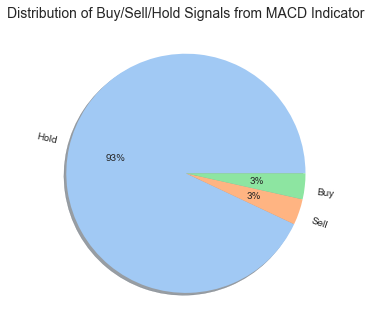

In [415]:
#Distrubition of the MACD Indicator
labels = ["Hold", "Sell", "Buy"]
values = dataset['MACD Indicator'].value_counts().tolist()
colours = sns.color_palette("pastel", 10)
plt.pie(x=values, labels=labels, autopct='%.0f%%', colors= colours, shadow=True, rotatelabels='true')
plt.title("Distribution of Buy/Sell/Hold Signals from MACD Indicator", fontdict={'fontsize': 14})
plt.show()

Addding Target Variable

In [416]:
# Recommender Based on the three indicators
def recommender(row): 
    # If All Share the Same Signal OutPut That Signal (Buy)
    if row['RSI Indicator'] == "Buy" and row['SO Indicator'] == 'Buy' and  row['Bollinger Indicator'] == 'Buy':
        return 'Buy'
     # If Any 2 Indicators Share the Same Signal Output That Signal (buy)
    elif row['RSI Indicator'] == 'Buy' and row['SO Indicator'] == 'Buy':
        return 'Buy'
    elif row['RSI Indicator'] == 'Buy' and row['Bollinger Indicator'] == 'Buy':
        return 'Buy'
    elif row['SO Indicator'] == 'Buy' and row['Bollinger Indicator'] == 'Buy':
        return 'Buy'   
    # If All Share the Same Signal Output That Signal (Sell)
    elif row['RSI Indicator'] == 'Sell' and row['SO Indicator'] == 'Sell' and  row['Bollinger Indicator'] == 'Sell':
        return 'Sell'
    # If Any 2 Indicators Share the Same Signal Output That Signal (Sell)
    elif row['RSI Indicator'] == 'Sell' and row['SO Indicator'] == 'Sell':
        return 'Sell'
    elif row['RSI Indicator'] == 'Sell' and row['Bollinger Indicator'] == 'Sell':
        return 'Sell'
    elif row['SO Indicator'] == 'Sell' and row['Bollinger Indicator'] == 'Sell':
        return 'Sell'    
    # If All Share the Same Signal OutPut That Signal (Hold)
    elif row['RSI Indicator'] == 'Hold' and row['SO Indicator'] == 'Hold' and  row['Bollinger Indicator'] == 'Hold':
        return 'Hold'
    # If Any 2 Indicators Share the Same Signal Output That Signal (Hold)
    elif row['RSI Indicator'] == 'Hold' and row['SO Indicator'] == 'Hold':
        return 'Hold'
    elif row['RSI Indicator'] == 'Hold' and row['Bollinger Indicator'] == 'Hold':
        return 'Hold'
    elif row['SO Indicator'] == 'Hold' and row['Bollinger Indicator'] == 'Hold':
        return 'Hold'      
    else:
        return 'Unclassed'

dataset['Recommender'] = dataset.apply(lambda row: recommender(row), axis=1)

In [417]:
# Distrubition of the Recommender
print(dataset['Recommender'].value_counts())


Hold    2018
Sell     389
Buy      111
Name: Recommender, dtype: int64


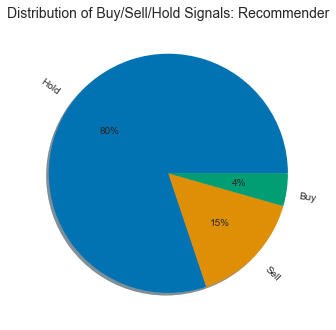

In [418]:
#Distrubition of the Recommender
labels = ["Hold", "Sell", "Buy"]
values = dataset['Recommender'].value_counts().tolist()
plt.style.use("seaborn")
colours = sns.color_palette("colorblind" )
plt.pie(x=values, labels=labels, autopct='%.0f%%', colors= colours, shadow=True, rotatelabels='true')
plt.title("Distribution of Buy/Sell/Hold Signals: Recommender", fontdict={'fontsize': 14})
plt.show()

Data Cleaning and Preprocessing

In [419]:
dataset.drop(['RSI Indicator', 'SO Indicator', 'MACD Indicator' , 'Bollinger Indicator'], axis = 1, inplace=True)

In [420]:
#Dataset shape after adding all the technical indicators 
dataset.shape

(2518, 13)

In [421]:
#Columns After Adding All The Technical Indicators
dataset.columns

Index(['Open', 'Close', 'High', 'Low', 'Volume', '%K', '%D', 'RSI',
       'Bollinger_Upper', 'Bollinger_Lower', 'MACD', 'Signal', 'Recommender'],
      dtype='object')

In [422]:
#Information regarding the dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2518 entries, 2012-04-30 to 2022-04-29
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open             2518 non-null   float64
 1   Close            2518 non-null   float64
 2   High             2518 non-null   float64
 3   Low              2518 non-null   float64
 4   Volume           2518 non-null   int64  
 5   %K               2505 non-null   float64
 6   %D               2503 non-null   float64
 7   RSI              2517 non-null   float64
 8   Bollinger_Upper  2499 non-null   float64
 9   Bollinger_Lower  2499 non-null   float64
 10  MACD             2518 non-null   float64
 11  Signal           2518 non-null   float64
 12  Recommender      2518 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 275.4+ KB


In [423]:
#Checking for Null Values
dataset.isna().sum()

Open                0
Close               0
High                0
Low                 0
Volume              0
%K                 13
%D                 15
RSI                 1
Bollinger_Upper    19
Bollinger_Lower    19
MACD                0
Signal              0
Recommender         0
dtype: int64

In [424]:
#Dropping Null Values
dataset = dataset.dropna()
dataset.isna().sum()

Open               0
Close              0
High               0
Low                0
Volume             0
%K                 0
%D                 0
RSI                0
Bollinger_Upper    0
Bollinger_Lower    0
MACD               0
Signal             0
Recommender        0
dtype: int64

In [425]:
#let's check if there is any duplicate data
print(dataset.duplicated().any())
print(dataset.duplicated().sum())

False
0


In [426]:
#Dataframe after dopping null values
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2499 entries, 2012-05-25 to 2022-04-29
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open             2499 non-null   float64
 1   Close            2499 non-null   float64
 2   High             2499 non-null   float64
 3   Low              2499 non-null   float64
 4   Volume           2499 non-null   int64  
 5   %K               2499 non-null   float64
 6   %D               2499 non-null   float64
 7   RSI              2499 non-null   float64
 8   Bollinger_Upper  2499 non-null   float64
 9   Bollinger_Lower  2499 non-null   float64
 10  MACD             2499 non-null   float64
 11  Signal           2499 non-null   float64
 12  Recommender      2499 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 273.3+ KB


In [427]:
# #Encode Categorical Variables
signal_dict = {'Hold': 0, 'Sell': 1, 'Buy': 2}

dataset['Recommender'] = dataset['Recommender'].map(signal_dict)

dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2499 entries, 2012-05-25 to 2022-04-29
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open             2499 non-null   float64
 1   Close            2499 non-null   float64
 2   High             2499 non-null   float64
 3   Low              2499 non-null   float64
 4   Volume           2499 non-null   int64  
 5   %K               2499 non-null   float64
 6   %D               2499 non-null   float64
 7   RSI              2499 non-null   float64
 8   Bollinger_Upper  2499 non-null   float64
 9   Bollinger_Lower  2499 non-null   float64
 10  MACD             2499 non-null   float64
 11  Signal           2499 non-null   float64
 12  Recommender      2499 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 273.3 KB


In [428]:
#Splitting the dataset into training and test sets
#Feature Scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

#Independant and Dependent Variable
y = dataset["Recommender"] #Dependent variable
x = dataset.drop(["Recommender"], axis=1) #Independent variable

#Splitting Data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size= 0.3, random_state= 0)


#Scaling
scaler = MinMaxScaler(feature_range=(0,1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [444]:
x

,Open,Close,High,Low,Volume,%K,%D,RSI,Bollinger_Upper,Bollinger_Lower,MACD,Signal
Date,,,,,,,,,,,,
2012-05-25,17.265852,17.195515,17.304385,17.078694,328507200,73.840217,79.791647,44.076228,18.186331,16.302008,-0.172952,-0.215631
2012-05-29,17.458816,17.500711,17.553618,17.287868,380508800,92.212657,81.823680,50.208212,18.132154,16.320373,-0.130183,-0.198541
2012-05-30,17.406830,17.711725,17.736802,17.326096,529429600,98.581570,88.211481,53.966532,18.116345,16.327130,-0.078358,-0.174505
2012-05-31,17.759736,17.667688,17.782979,17.475944,491674400,93.644678,94.812968,53.066319,18.068705,16.349541,-0.040374,-0.147679
2012-06-01,17.405609,17.155760,17.512338,17.141388,520987600,65.424827,85.883692,43.898813,17.991824,16.362721,-0.050992,-0.128341
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-25,161.119995,162.880005,163.169998,158.460007,96046400,22.278221,14.362295,41.927588,180.981810,159.888189,-1.131611,-0.008625
2022-04-26,162.250000,156.800003,162.339996,156.720001,95623200,0.473104,8.152724,34.919440,181.370947,157.619052,-1.831394,-0.373179
2022-04-27,155.910004,156.570007,159.789993,155.380005,88063200,6.618480,9.789935,34.683271,180.707184,156.043816,-2.377134,-0.773970


In [429]:
print("x_train dataset: ", X_train.shape)
print(" y_train dataset: ", y_train.shape)
print(" x_test dataset: ", X_test.shape)
print("y_test dataset: ", y_test.shape)

x_train dataset:  (1749, 12)
 y_train dataset:  (1749,)
 x_test dataset:  (750, 12)
y_test dataset:  (750,)


Text(0.5, 0, 'Trade Signals')

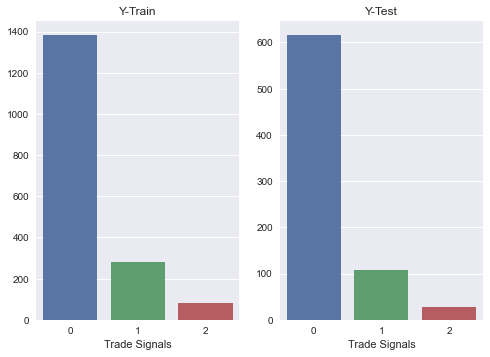

In [430]:
#Handling Imbalance datausing SMOTE
#Synthetic Minority Oversampling Technique
#Stroke (Dependant Variable) before SMOTE
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.barplot(x=['0', '1','2'], y =[sum(y_train == 0), sum(y_train == 1), sum(y_train == 2)], ax = ax1)
ax1.set_title("Y-Train")
ax1.set_xlabel('Trade Signals')

sns.barplot(x=['0', '1', '2'], y =[sum(y_test == 0), sum(y_test == 1), sum(y_test == 2)], ax = ax2)
ax2.set_title("Y-Test")
ax2.set_xlabel('Trade Signals')

Text(0.5, 0, 'Trade Signals')

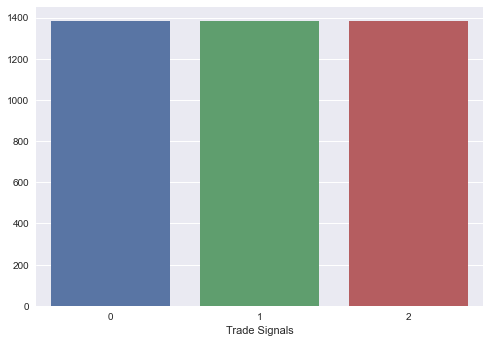

In [431]:
#Handling Imbalance datausing SMOTE
#Synthetic Minority Oversampling Technique
#Stroke (Dependant Variable) After SMOTE
sm = SMOTE(random_state=42)
X_train_smote, Y_train_smote = sm.fit_resample(X_train, y_train)

X_test_smote, y_test_smote = sm.fit_resample(X_test, y_test)

fig = sns.barplot(x=['0', '1', '2'], y =[sum(Y_train_smote == 0), sum(Y_train_smote == 1), sum(Y_train_smote == 2)])
fig.set_xlabel('Trade Signals')

In [432]:
print(X_train_smote.shape)
print(Y_train_smote.shape)

(4149, 12)
(4149,)


Logistic Regression with SMOTE

In [433]:
#Models
from sklearn.linear_model import LogisticRegression
#Model Result Analysis
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, roc_curve, plot_roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score

#Data Modelling
#Logistic Regresion
lr = LogisticRegression()
lr.fit(X_train_smote,Y_train_smote)


#Predictions
y_pred = lr.predict(X_test)
y_pred_train = lr.predict(X_train)

#Confusion Matrix
cm_test = confusion_matrix(y_test, y_pred)  
print("Test Data Confusion Matrix :")
print(cm_test)
#Precision
test_precision = precision_score(y_test, y_pred,  average='macro')
print("Test Data Precision Score :", test_precision) 
#Recall
test_recall = recall_score(y_test, y_pred,  average='macro')
print("Test Data Recall Score : ", test_recall)
#F1 Score
test_f1 = f1_score(y_test, y_pred,average='macro')
print("Test  Data F1 Score: ", test_f1)


# #Confusion Matrix
# cm_train = confusion_matrix(y_train, y_pred_train)  
# print("Train Data Confusion Matrix :")
# print(cm_test)
# #Precision
# train_precision = precision_score(y_train, y_pred_train,  average='macro')
# print("Train Dat Precision Score : ", train_precision)
# #Recall
# train_recall = recall_score(y_train, y_pred_train,  average='macro')
# print("Train Data Recall Score : ", train_recall)
# #F1
# train_f1 = f1_score(y_train, y_pred_train,average='macro')
# print("Train  Data F1 Score: ", train_f1)


#Storing Results for the Model
list_1 = []
list_2 = []

list_2.append("Logistic Regression")
list_2.append((accuracy_score(y_test, y_pred))*100) 
list_2.append(test_precision)
list_2.append(test_recall)
list_2.append(test_f1)
list_1.append(list_2)
list_2 = []

# list_2.append("Logistic Regression Train Data")
# list_2.append(train_precision)
# list_2.append(train_recall)
# list_2.append(train_f1)
# list_1.append(list_2)
# list_2 = []


Test Data Confusion Matrix :
[[514  65  37]
 [  6 101   0]
 [  0   0  27]]
Test Data Precision Score : 0.6729234244670992
Test Data Recall Score :  0.9261136060201481
Test  Data F1 Score:  0.7460876369327073


In [434]:
#Models
from sklearn.linear_model import LogisticRegression
#Model Result Analysis
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, roc_curve, plot_roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score

#Data Modelling
#Logistic Regresion
lr = LogisticRegression()
lr.fit(X_train_smote,Y_train_smote)


#Predictions
y_pred = lr.predict(X_test_smote)
y_pred_train = lr.predict(X_train)

#Confusion Matrix
cm_test = confusion_matrix(y_test_smote, y_pred)  
print("Test Data Confusion Matrix :")
print(cm_test)
#Precision
test_precision = precision_score(y_test_smote, y_pred,  average='macro')
print("Test Data Precision Score :", test_precision) 
#Recall
test_recall = recall_score(y_test_smote, y_pred,  average='macro')
print("Test Data Recall Score : ", test_recall)
#F1 Score
test_f1 = f1_score(y_test_smote, y_pred,average='macro')
print("Test  Data F1 Score: ", test_f1)



list_2.append("Logistic Regression with Test SMOTE")
list_2.append((accuracy_score(y_test_smote, y_pred))*100) 
list_2.append(test_precision)
list_2.append(test_recall)
list_2.append(test_f1)
list_1.append(list_2)
list_2 = []


Test Data Confusion Matrix :
[[514  65  37]
 [ 21 595   0]
 [  0   0 616]]
Test Data Precision Score : 0.9352004176817047
Test Data Recall Score :  0.9334415584415584
Test  Data F1 Score:  0.9321938225381997


Logistic Regression without SMOTE

In [435]:

# #Splitting Data
# # X_train, X_test, y_train, y_test = train_test_split(x, y, test_size= 0.3, random_state= 0)
# #Logistic Regresion
# lr = LogisticRegression(solver='lbfgs')
# lr.fit(X_train,y_train)

# y_pred = lr.predict(X_test)


# #Confusion Matrix
# cm_test = confusion_matrix(y_test, y_pred)  
# print("Test Data Confusion Matrix :")
# print(cm_test)
# #Precision
# test_precision = precision_score(y_test, y_pred,  average='macro')
# print("Test Data Precision Score :", test_precision) 
# #Recall
# test_recall = recall_score(y_test, y_pred,  average='macro')
# print("Test Data Recall Score : ", test_recall)
# #F1 Score
# test_f1 = f1_score(y_test, y_pred,average='macro')
# print("Test  Data F1 Score: ", test_f1)



# #Storing results
# list_2.append("Logistic Regression without SMOTE")
# list_2.append((accuracy_score(y_test, y_pred))*100) 
# list_2.append(test_precision)
# list_2.append(test_recall)
# list_2.append(test_f1)
# list_1.append(list_2)
# list_2 = []

Decision Tree

In [436]:
#Data Modelling
#Decision Tree
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train_smote,Y_train_smote)


#Predictions
y_pred = decision_tree.predict(X_test)
y_pred_train = decision_tree.predict(X_train_smote)


#Confusion Matrix
cm_test = confusion_matrix(y_test, y_pred)  
print("Test Data Confusion Matrix :")
print(cm_test)
#Precision
test_precision = precision_score(y_test, y_pred,  average='macro')
print("Test Data Precision Score :", test_precision) 
#Recall
test_recall = recall_score(y_test, y_pred,  average='macro')
print("Test Data Recall Score : ", test_recall)
#F1 Score
test_f1 = f1_score(y_test, y_pred,average='macro')
print("Test  Data F1 Score: ", test_f1)


# #Confusion Matrix
# cm_train = confusion_matrix(y_train, y_pred_train)  
# print("Train Data Confusion Matrix :")
# print(cm_test)
# #Precision
# train_precision = precision_score(y_train, y_pred_train,  average='macro')
# print("Train Dat Precision Score : ", train_precision)
# #Recall
# train_recall = recall_score(y_train, y_pred_train,  average='macro')
# print("Train Data Recall Score : ", train_recall)
# #F1
# train_f1 = f1_score(y_train, y_pred_train,average='macro')
# print("Train  Data F1 Score: ", train_f1)


list_2.append("Decision Tree")
list_2.append((accuracy_score(y_test, y_pred))*100) 
list_2.append(test_precision)
list_2.append(test_recall)
list_2.append(test_f1)
list_1.append(list_2)
list_2 = []

# list_2.append("Decision Tree Train Data")
# list_2.append(train_precision)
# list_2.append(train_recall)
# list_2.append(train_f1)
# list_1.append(list_2)
# list_2 = []


Test Data Confusion Matrix :
[[568  33  15]
 [ 16  91   0]
 [  2   0  25]]
Test Data Precision Score : 0.7760514147308157
Test Data Recall Score :  0.899490379241158
Test  Data F1 Score:  0.8264129862461002


Decision Tree without SMOTE

In [437]:
# #Data Modelling
# #Decision Tree
# decision_tree = DecisionTreeClassifier()
# decision_tree.fit(X_train, y_train)
# y_pred = decision_tree.predict(X_test)

# #Confusion Matrix
# cm_test = confusion_matrix(y_test, y_pred)  
# print("Test Data Confusion Matrix :")
# print(cm_test)
# #Precision
# test_precision = precision_score(y_test, y_pred,  average='macro')
# print("Test Data Precision Score :", test_precision) 
# #Recall
# test_recall = recall_score(y_test, y_pred,  average='macro')
# print("Test Data Recall Score : ", test_recall)
# #F1 Score
# test_f1 = f1_score(y_test, y_pred,average='macro')
# print("Test  Data F1 Score: ", test_f1)



# #Storing results
# list_2.append("Decision Tree without SMOTE")
# list_2.append((accuracy_score(y_test, y_pred))*100) 
# list_2.append(test_precision)
# list_2.append(test_recall)
# list_2.append(test_f1)
# list_1.append(list_2)
list_2 = []

Random  Forest 

In [438]:
#Data Modelling
#Random Forest
random_forest = RandomForestClassifier()
random_forest.fit(X_train_smote,Y_train_smote)


#Predictions
y_pred = random_forest.predict(X_test)
y_pred_train = random_forest.predict(X_train_smote)

#Confusion Matrix
cm_test = confusion_matrix(y_test, y_pred)  
print("Test Data Confusion Matrix :")
print(cm_test)
#Precision
test_precision = precision_score(y_test, y_pred,  average='macro')
print("Test Data Precision Score :", test_precision) 
#Recall
test_recall = recall_score(y_test, y_pred,  average='macro')
print("Test Data Recall Score : ", test_recall)
#F1 Score
test_f1 = f1_score(y_test, y_pred,average='macro')
print("Test  Data F1 Score: ", test_f1)


# #Confusion Matrix
# cm_train = confusion_matrix(y_train, y_pred_train)  
# print("Train Data Confusion Matrix :")
# print(cm_test)
# #Precision
# train_precision = precision_score(y_train, y_pred_train,  average='macro')
# print("Train Dat Precision Score : ", train_precision)
# #Recall
# train_recall = recall_score(y_train, y_pred_train,  average='macro')
# print("Train Data Recall Score : ", train_recall)
# #F1
# train_f1 = f1_score(y_train, y_pred_train,average='macro')
# print("Train  Data F1 Score: ", train_f1)




list_2.append("Random Forest")
list_2.append((accuracy_score(y_test, y_pred))*100) 
list_2.append(test_precision)
list_2.append(test_recall)
list_2.append(test_f1)
list_1.append(list_2)
list_2 = []

# list_2.append("Logistic Regression Train Data")
# list_2.append(train_precision)
# list_2.append(train_recall)
# list_2.append(train_f1)
# list_1.append(list_2)
# list_2 = []

Test Data Confusion Matrix :
[[591  11  14]
 [ 14  93   0]
 [  2   0  25]]
Test Data Precision Score : 0.8362990889761894
Test Data Recall Score :  0.9181667962820611
Test  Data F1 Score:  0.8685227414131941


Random Forest without SMOTE

In [439]:
# #Data Modelling
# #Random Forest
# random_forest = RandomForestClassifier()
# random_forest.fit(X_train, y_train)
# y_pred = random_forest.predict(X_test)

# #Confusion Matrix
# cm_test = confusion_matrix(y_test, y_pred)  
# print("Test Data Confusion Matrix :")
# print(cm_test)
# #Precision
# test_precision = precision_score(y_test, y_pred,  average='macro')
# print("Test Data Precision Score :", test_precision) 
# #Recall
# test_recall = recall_score(y_test, y_pred,  average='macro')
# print("Test Data Recall Score : ", test_recall)
# #F1 Score
# test_f1 = f1_score(y_test, y_pred,average='macro')
# print("Test  Data F1 Score: ", test_f1)



# #Storing results
# list_2.append("Random Forest without SMOTE")
# list_2.append((accuracy_score(y_test, y_pred))*100) 
# list_2.append(test_precision)
# list_2.append(test_recall)
# list_2.append(test_f1)
# list_1.append(list_2)
list_2 = []

In [440]:
from sklearn.svm import SVC

#Data Modelling
#Support Vector Machine
svc = SVC()
svc.fit(X_train_smote,Y_train_smote)


#Predictions
y_pred = svc.predict(X_test)
y_pred_train = svc.predict(X_train_smote)

#Confusion Matrix
cm_test = confusion_matrix(y_test, y_pred)  
print("Test Data Confusion Matrix :")
print(cm_test)
#Precision
test_precision = precision_score(y_test, y_pred,  average='macro')
print("Test Data Precision Score :", test_precision) 
#Recall
test_recall = recall_score(y_test, y_pred,  average='macro')
print("Test Data Recall Score : ", test_recall)
#F1 Score
test_f1 = f1_score(y_test, y_pred,average='macro')
print("Test  Data F1 Score: ", test_f1)

#Appending Results 
list_2.append("SVM")
list_2.append((accuracy_score(y_test, y_pred))*100) 
list_2.append(test_precision)
list_2.append(test_recall)
list_2.append(test_f1)
list_1.append(list_2)
list_2 = []


Test Data Confusion Matrix :
[[531  57  28]
 [  4 103   0]
 [  1   0  26]]
Test Data Precision Score : 0.7053010410908421
Test Data Recall Score :  0.9291975908019521
Test  Data F1 Score:  0.7784619630554399


In [441]:
#Data Modelling
#K Nearest Neighbours

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train_smote, Y_train_smote)
y_pred = knn.predict(X_test)

#Confusion Matrix
cm_test = confusion_matrix(y_test, y_pred)  
print("Test Data Confusion Matrix :")
print(cm_test)
#Precision
test_precision = precision_score(y_test, y_pred,  average='macro')
print("Test Data Precision Score :", test_precision) 
#Recall
test_recall = recall_score(y_test, y_pred,  average='macro')
print("Test Data Recall Score : ", test_recall)
#F1 Score
test_f1 = f1_score(y_test, y_pred,average='macro')
print("Test  Data F1 Score: ", test_f1)

#Appending Results 
list_2.append("KNN")
list_2.append((accuracy_score(y_test, y_pred))*100) 
list_2.append(test_precision)
list_2.append(test_recall)
list_2.append(test_f1)
list_1.append(list_2)
list_2 = []


Test Data Confusion Matrix :
[[549  41  26]
 [ 11  96   0]
 [  0   0  27]]
Test Data Precision Score : 0.7301736773761976
Test Data Recall Score :  0.929476675972003
Test  Data F1 Score:  0.7985195717631314


In [442]:
#Data Modelling
#Niave Bayes
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train_smote, Y_train_smote)
y_pred = gnb.predict(X_test)


#Confusion Matrix
cm_test = confusion_matrix(y_test, y_pred)  
print("Test Data Confusion Matrix :")
print(cm_test)
#Precision
test_precision = precision_score(y_test, y_pred,  average='macro')
print("Test Data Precision Score :", test_precision) 
#Recall
test_recall = recall_score(y_test, y_pred,  average='macro')
print("Test Data Recall Score : ", test_recall)
#F1 Score
test_f1 = f1_score(y_test, y_pred,average='macro')
print("Test  Data F1 Score: ", test_f1)

#Appending Results 
list_2.append("Niave Byaes")
list_2.append((accuracy_score(y_test, y_pred))*100) 
list_2.append(test_precision)
list_2.append(test_recall)
list_2.append(test_f1)
list_1.append(list_2)
list_2 = []

Test Data Confusion Matrix :
[[549  41  26]
 [ 11  96   0]
 [  0   0  27]]
Test Data Precision Score : 0.7301736773761976
Test Data Recall Score :  0.929476675972003
Test  Data F1 Score:  0.7985195717631314


In [443]:
#Displaying all the results from the model
model_results = pd.DataFrame(list_1, columns= ['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])
model_results.sort_values(by= ['F1'], inplace= True, ascending= False)
model_results


,Model,Accuracy,Precision,Recall,F1
1,Logistic Regression with Test SMOTE,93.344156,0.935200,0.933442,0.932194
3,Random Forest,94.533333,0.836299,0.918167,0.868523
2,Decision Tree,91.200000,0.776051,0.899490,0.826413
5,KNN,89.600000,0.730174,0.929477,0.798520
6,Niave Byaes,89.600000,0.730174,0.929477,0.798520
4,SVM,88.000000,0.705301,0.929198,0.778462
0,Logistic Regression,85.600000,0.672923,0.926114,0.746088
